In [43]:
!pip install shap
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
!wget -O student-mat.csv \
"https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/04_Apply/Students_Alcohol_Consumption/student-mat.csv"

--2025-06-29 23:02:57--  https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/04_Apply/Students_Alcohol_Consumption/student-mat.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41983 (41K) [text/plain]
Saving to: ‘student-mat.csv’

student-mat.csv     100%[===================>]  41.00K  --.-KB/s    in 0.05s   

2025-06-29 23:02:57 (767 KB/s) - ‘student-mat.csv’ saved [41983/41983]



In [44]:
import pandas as pd
df = pd.read_csv("student-mat.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [45]:
# Create elite dropout flag
df['dropout_flag'] = df.apply(lambda row:
                              1 if (row['G3'] < 10 or
                                    row['failures'] >= 1 or
                                    row['absences'] >= 15)
                              else 0, axis=1)

In [46]:
# Check balance
df['dropout_flag'].value_counts(normalize=True)


,proportion
dropout_flag,
0,0.567089
1,0.432911


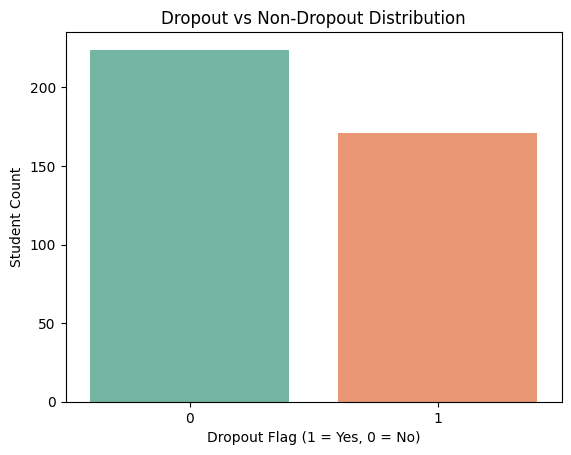

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot target variable distribution
sns.countplot(x='dropout_flag', data=df, palette='Set2')
plt.title('Dropout vs Non-Dropout Distribution')
plt.xlabel('Dropout Flag (1 = Yes, 0 = No)')
plt.ylabel('Student Count')
plt.show()


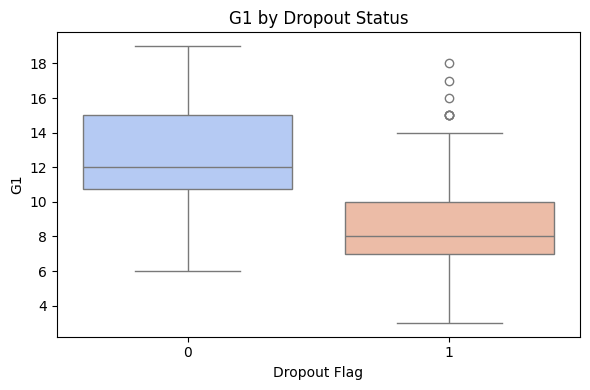

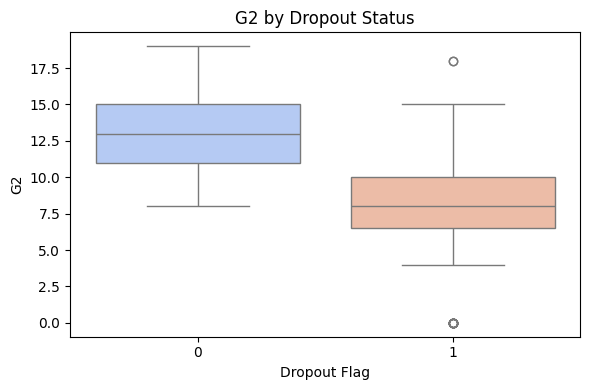

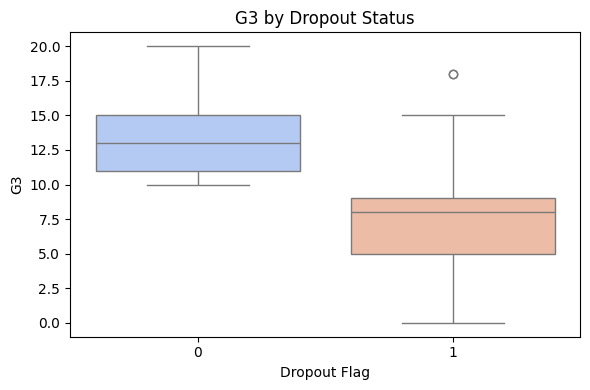

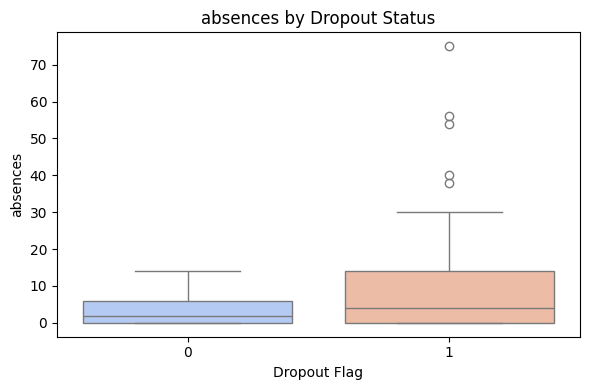

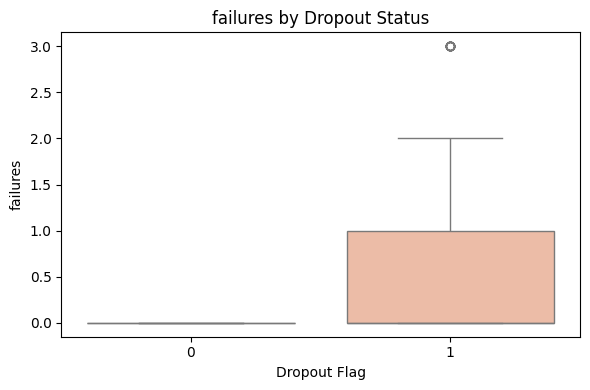

In [48]:
# Numerical columns for comparison
num_cols = ['G1', 'G2', 'G3', 'absences', 'failures']

# Plot boxplots
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='dropout_flag', y=col, data=df, palette='coolwarm')
    plt.title(f'{col} by Dropout Status')
    plt.xlabel('Dropout Flag')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


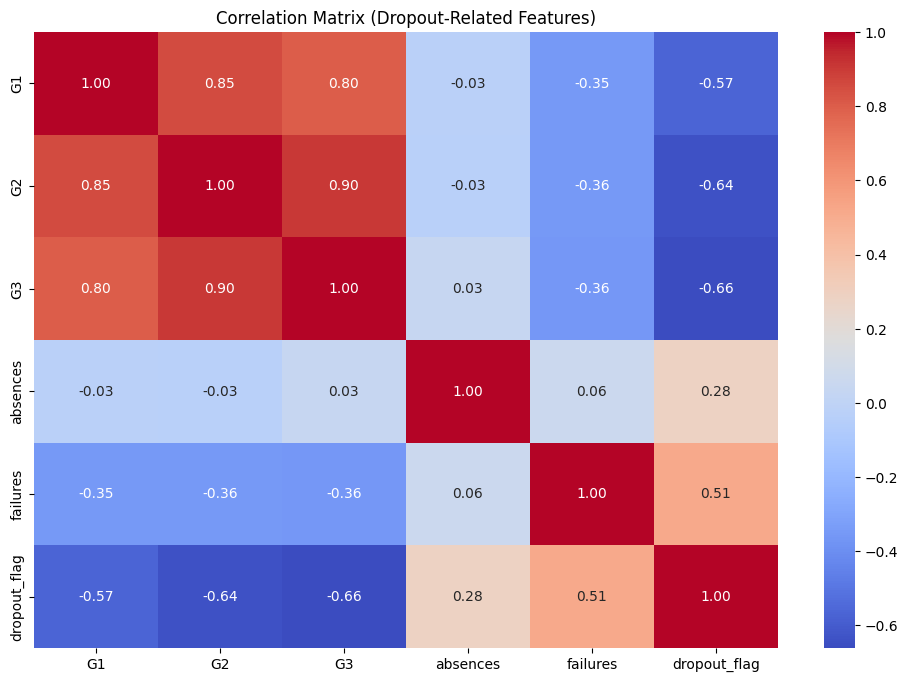

In [49]:
# Get correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols + ['dropout_flag']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Dropout-Related Features)")
plt.show()


In [50]:
# Drop columns not useful for prediction
# 'G1', 'G2', and 'G3' are highly correlated – we may exclude G1/G2 if using G3 as proxy
df_clean = df.drop(columns=['G1', 'G2', 'G3'])  # optional: keep if helpful


In [51]:
# Identify categorical columns
cat_cols = df_clean.select_dtypes(include=['object']).columns

# One-hot encode all categorical columns
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
df_encoded.head()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,True,False,True,False,False,False,True,True,False,False
1,17,1,1,1,2,0,5,3,3,1,...,False,False,False,True,False,False,False,True,True,False
2,15,1,1,1,2,3,4,3,2,2,...,True,False,True,False,True,False,True,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,True,False,False,True,True,True,True,True,True,True
4,16,3,3,1,2,0,4,3,2,1,...,False,False,False,True,True,False,True,True,False,False


In [52]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_encoded.drop('dropout_flag', axis=1)
y = df_encoded['dropout_flag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [53]:
print(X.columns.tolist())

['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes']


In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize and apply scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

# Function to evaluate
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")
    print()

# Loop through models
for name, model in models.items():
    evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)


--- Logistic Regression ---
Accuracy: 0.785
Precision: 0.870
Recall: 0.588
F1 Score: 0.702
ROC AUC: 0.866

--- Random Forest ---
Accuracy: 0.835
Precision: 0.957
Recall: 0.647
F1 Score: 0.772
ROC AUC: 0.892

--- XGBoost ---
Accuracy: 0.810
Precision: 0.828
Recall: 0.706
F1 Score: 0.762
ROC AUC: 0.870

[LightGBM] [Info] Number of positive: 137, number of negative: 179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433544 -> initscore=-0.267405
[LightGBM] [Info] Start training from score -0.267405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [56]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [20, 30, 40]
}


In [57]:
lgbm = LGBMClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',  # optimize for AUC
    cv=cv,
    verbose=1,
    n_jobs=-1
)


In [58]:
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 137, number of negative: 179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 164
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433544 -> initscore=-0.267405
[LightGBM] [Info] Start training from score -0.267405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [20, 30, 40]},
             scoring='roc_auc', verbose=1)

In [59]:
print("Best ROC AUC Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)


Best ROC AUC Score: 0.8479967666078778
Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 20}


In [60]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Use best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85        45
           1       0.88      0.65      0.75        34

    accuracy                           0.81        79
   macro avg       0.83      0.79      0.80        79
weighted avg       0.82      0.81      0.80        79

Test ROC AUC Score: 0.8803921568627451
Confusion Matrix:
 [[42  3]
 [12 22]]


In [61]:
import shap
shap.initjs()                       # enable interactive JS visual

# Build a TreeExplainer for the tuned model
explainer = shap.TreeExplainer(best_model)      # best_model came from GridSearchCV
shap_values = explainer.shap_values(X_test_scaled)  # SHAP values for the test set


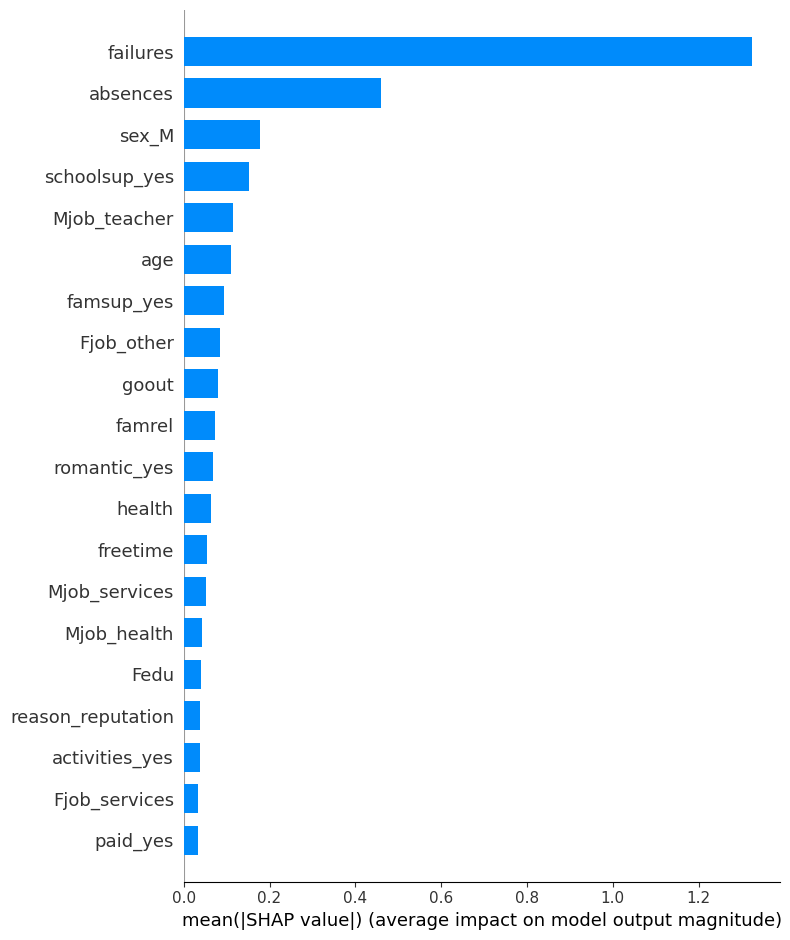

In [62]:
shap.summary_plot(
    shap_values,              # pass full SHAP values matrix
    X_test_scaled,
    feature_names=X_test.columns,
    plot_type="bar"           # or "dot" for beeswarm
)


In [63]:
# Force plot for a single prediction (e.g., student #10)
student_idx = 10  # you can change this index to test others

shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[student_idx],
    X_test_scaled[student_idx],
    feature_names=X_test.columns
)


In [64]:
import joblib

# Save the tuned model
joblib.dump(best_model, "dropout_predictor_model.pkl")
print("Model saved as dropout_predictor_model.pkl")


Model saved as dropout_predictor_model.pkl


In [65]:
def predict_dropout(features_dict):
    """
    Predict if a student will drop out based on input features.

    Args:
        features_dict (dict): Keys are feature names, values are the corresponding values.

    Returns:
        str: 'Dropout' or 'Continue'
    """
    import numpy as np
    import pandas as pd

    # Load the model if not already in memory
    model = joblib.load("dropout_predictor_model.pkl")

    # Convert dict to DataFrame
    input_df = pd.DataFrame([features_dict])

    # Apply the same scaler used during training
    input_scaled = scaler.transform(input_df)

    # Predict
    prediction = model.predict(input_scaled)[0]

    return "Dropout" if prediction == 1 else "Continue"


In [66]:
example_student = {
    'age': 17,
    'Medu': 4,
    'Fedu': 3,
    'traveltime': 1,
    'studytime': 2,
    'failures': 0,
    'famrel': 4,
    'freetime': 3,
    'goout': 2,
    'Dalc': 1,
    'Walc': 2,
    'health': 4,
    'absences': 2,
    'school_MS': 1,
    'sex_M': 1,
    'address_U': 1,
    'famsize_LE3': 0,
    'Pstatus_T': 1,
    'Mjob_health': 0,
    'Mjob_other': 0,
    'Mjob_services': 1,
    'Mjob_teacher': 0,
    'Fjob_health': 0,
    'Fjob_other': 1,
    'Fjob_services': 0,
    'Fjob_teacher': 0,
    'reason_home': 0,
    'reason_other': 0,
    'reason_reputation': 1,
    'guardian_mother': 1,
    'guardian_other': 0,
    'schoolsup_yes': 0,
    'famsup_yes': 1,
    'paid_yes': 0,
    'activities_yes': 1,
    'nursery_yes': 1,
    'higher_yes': 1,
    'internet_yes': 1,
    'romantic_yes': 0
}

predict_dropout(example_student)


'Continue'

In [67]:
predict_dropout(example_student)


'Continue'

In [68]:
import joblib
joblib.dump(best_model, 'final_dropout_model.pkl')


['final_dropout_model.pkl']

In [71]:
from google.colab import files
files.download('final_dropout_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
# Export all installed packages into a requirements.txt file
!pip freeze > requirements.txt
